# Autoencoder

In [1]:
import os
import random
import cv2
import numpy as np
import collections

import torch
import torchvision
import torch.nn as nn

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

from utils import (
    Collector,
    AELoss,
    VAELoss,
    trainer,
    plot_latent_tsne,
    generate_samples_between_centers,
    visualize_prediction,
)

import models

%matplotlib inline

## Set Seeds

In [2]:
seed = 0

torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

g = torch.Generator()
g.manual_seed(seed)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

## Define basics params

In [3]:
NAME = 'image_compression'
PROJECT = 'dl_course'
ENTITY = 'ilyabasharov'
TAGS = ['Image Compression', 'Neural Net', 'GAN', ]

CONFIG = {
    'device': torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    'learning_rate': 5e-3,
    'epochs': 50,
    'num_workers': 10,
    'seed': 0,
    'batch_size': 8,
    'image_size': (256, 256),
    'mean': (0, 0, 0),
    'std': (1, 1, 1),
    'weight_decay': 1e-3,
    'betas': (0.9, 0.999),
    'dataset': 'flickr-image-dataset',
    'model': 'resnet18',
    'lr_scheduler': 'ReduceOnPlatou',
    'data_path': 'datasets/flickr30k',
    'train_size': 0.9,
}

## Define Generator for train/test data

In [4]:
class ImageFlickr30k(torch.utils.data.Dataset):
    
    ext = ['jpg', 'png', 'jpeg', ]
    
    def __init__(
        self,
        root: str,
        split: str,
        transform: A.core.composition.Compose,
    ) -> None:
        
        super().__init__()
        
        self.root = root
        self.transform = transform
        
        with open(os.path.join(root, f'{split}.txt'), 'r') as file:
            self.files_name = file.read().split('\n')
            
        self.files_name.pop()

    def __getitem__(
        self,
        idx: int,
    ) -> dict:
        
        img_path = os.path.join(self.root, 'images', self.files_name[idx])
        
        assert os.path.exists(img_path), f'Image path {img_path} does not exist!'
        file_ext = img_path.split('.')[1].lower()
        assert file_ext in self.ext, f'File ext {file_ext} is not in {self.ext}!'
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        output = self.transform(
            image=image,
            test_image=image,
        )
        
        return output
        
    
    def __len__(
        self,
    ) -> int:
        
        return len(self.files_name)
    
    
in_tf = A.Compose([
    A.LongestMaxSize(max_size=max(CONFIG['image_size'])),
    A.PadIfNeeded(
        position=A.PadIfNeeded.PositionType.TOP_LEFT,
        min_height=CONFIG['image_size'][0],
        min_width=CONFIG['image_size'][1],
        value=0,
        border_mode=cv2.BORDER_CONSTANT,
    ),
], additional_targets = {
    'test_image': 'image',
})

middle_tf = A.Compose([
    A.CoarseDropout(
        max_holes=4,
        min_holes=1,
        max_height=0.2,
        min_height=0.05,
        max_width=0.2,
        min_width=0.05,
        fill_value=[0, 0.5, 1],
        p=0.5,
    ),
    A.OneOf([
        A.RandomBrightnessContrast(
            brightness_limit=(-0.5, 0.5),
            contrast_limit=(-0.5, 0.5),
            p=1,
        ),
        A.Blur(
            p=1,
        ),
        A.GaussNoise(
            var_limit=5.0 / 255.0,
            p=1,
        ),
    ], p=0.5)
])

out_tf = A.Compose([
    A.Normalize(
        mean=CONFIG['mean'],
        std=CONFIG['std'],
        max_pixel_value=255.,
    ),
    ToTensorV2(),
], additional_targets = {
    'test_image': 'image',
})
    
transformations = {
    'train': A.Compose([
        in_tf,
        middle_tf,
        out_tf,
    ]),
    'test': A.Compose([
        in_tf,
        out_tf,
    ]),
}

datasets = {
    phase: ImageFlickr30k(
        root=CONFIG['data_path'],
        split=phase,
        transform=transformations[phase],
    )
    for phase in transformations
}

dataloaders = {
    phase: torch.utils.data.DataLoader(
        dataset=datasets[phase],
        batch_size=CONFIG['batch_size'],
        shuffle=True,
        num_workers=CONFIG['num_workers'],
        pin_memory=True,
        drop_last=True if phase == 'train' else False,
        worker_init_fn=seed_worker,
        generator=g,
    )
    for phase in transformations
}

## Lets visualize a batch!

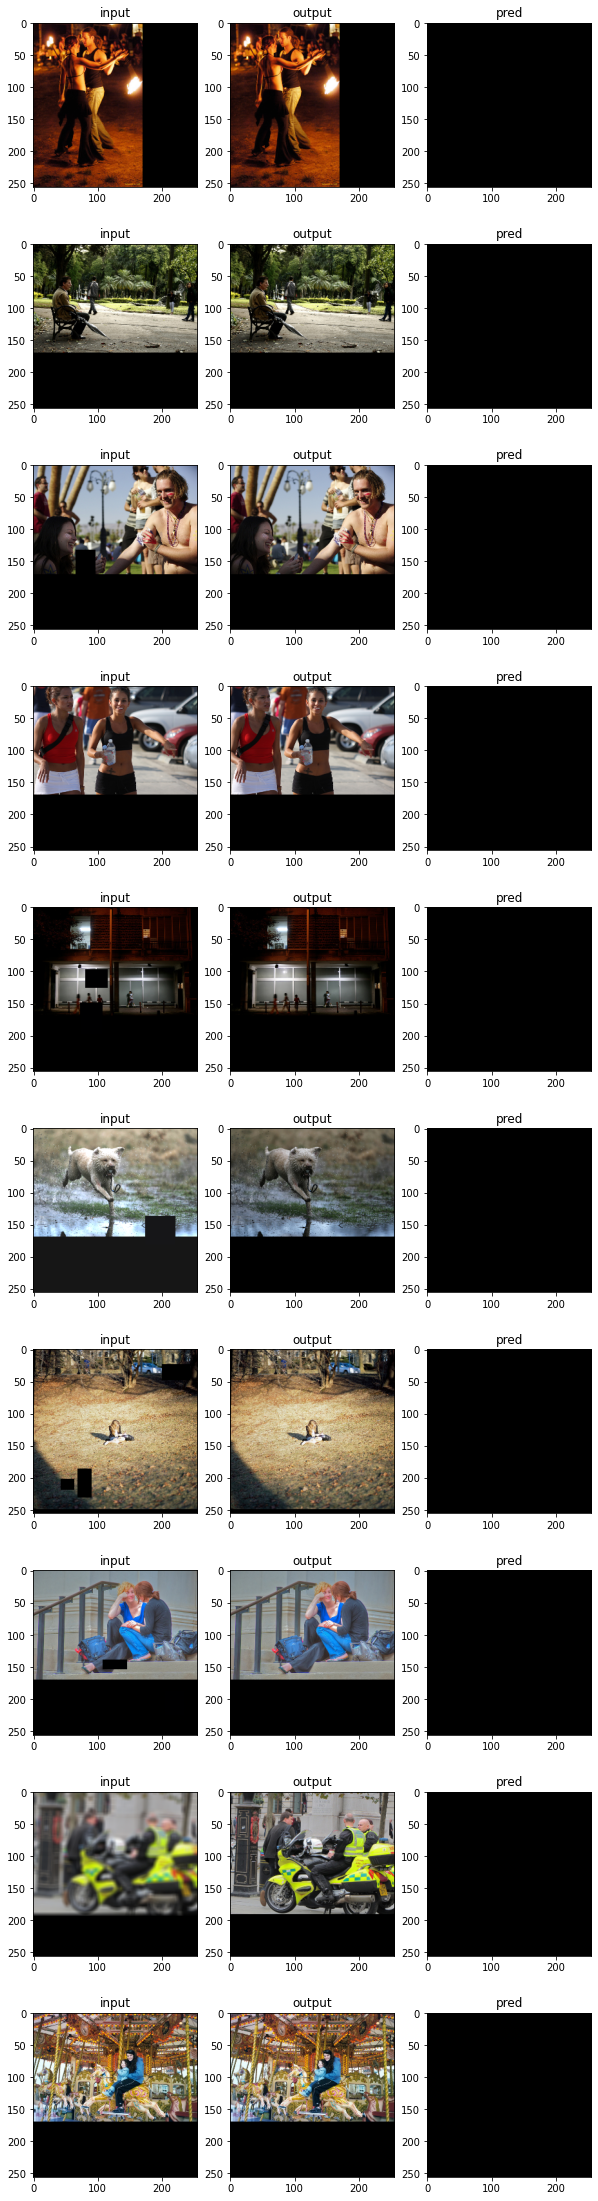

In [5]:
visualize_prediction(
    model=None,
    dataset=datasets['train'],
)

## Define model
![alt text](pics/ae.png "Title")

In [6]:
class AutoEncoder(nn.Module):
    
    def __init__(
        self,
        downlayers: nn.Module,
        middlelayers: nn.Module,
        uplayers: nn.Module,
    ) -> None:
        
        super().__init__()
        
        self.down = downlayers()
        self.middle = middlelayers()
        self.up = uplayers()
        
    def forward(
        self,
        x: torch.Tensor,
        embedding: bool=True,
        **kwargs,
    ) -> torch.Tensor:
        
        x = self.down(x)
        
        middle = self.middle(x, embedding)
        
        if embedding:
            return middle
            
        
        x = self.up(middle)
        
        return {
            'pred_image': x.sigmoid(),
            'latent_repr': middle,
        }
    
class CompressionMiddleLayer(nn.Module):
    
    def __init__(
        self,
        expected_dim: tuple = (CONFIG['image_size'][0] // 32, CONFIG['image_size'][1] // 32),
        hidden_dim: int=512,
        **kwargs,
    ) -> None:
        
        super().__init__()
        
        self.agg = nn.AdaptiveAvgPool2d((1, 1))
        self.up = nn.ConvTranspose2d(
            in_channels=hidden_dim,
            out_channels=hidden_dim,
            kernel_size=expected_dim,
            stride=2,
        )
    
    def forward(
        self,
        x: torch.Tensor,
        embedding: bool=True,
    ) -> torch.Tensor:
        
        x = self.agg(x)
        
        if embedding:
            
            return x.flatten(
                start_dim=1,
                end_dim=-1,
            )
        
        x = self.up(x)
        
        return x
    
class MiddleLayer(nn.Module):
    
    def __init__(
        self,
        **kwargs,
    ) -> None:
        
        super().__init__()
        
        self.agg = nn.AdaptiveAvgPool2d((1, 1))
    
    def forward(
        self,
        x: torch.Tensor,
        embedding: bool=True,
    ) -> torch.Tensor:
        
        if embedding:
            
            x = self.agg(x).flatten(start_dim=1, end_dim=-1)
            return x
        
        return x

In [7]:
mode = 'no_compress'

bottleneck = {
    'compress': CompressionMiddleLayer,
    'no_compress': MiddleLayer,
}


model = AutoEncoder(
    downlayers=models.resnet34,
    middlelayers=bottleneck[mode],
    uplayers=models.deconv_resnet34,
).to(CONFIG['device'])

## Define trainer params

In [8]:
lr=CONFIG['learning_rate']

optimizer = torch.optim.AdamW(
    params=model.parameters(),
    lr=lr,
    weight_decay=1e-3,
)
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer=optimizer,
    max_lr=lr,
    steps_per_epoch=len(dataloaders['train']),
    epochs=CONFIG['epochs'],
)
loss = AELoss(weights=[1e4, 1])

save_path=f'metrics/AE/epoch={CONFIG["epochs"]}_bs={CONFIG["batch_size"]}_lr={lr}_loss={loss.__class__.__name__}_bn-mode={mode}'
visualiser = Collector(
    root_graphics=save_path,
    root_desc=save_path,
    phases=list(transformations.keys()),
)

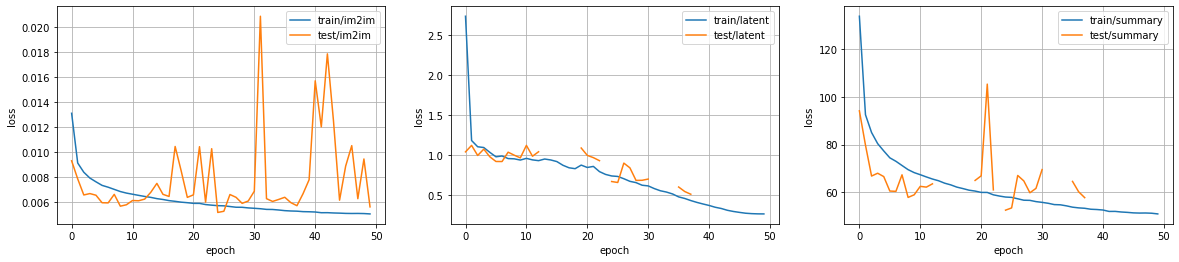

In [9]:
trainer(model, optimizer, scheduler, dataloaders, CONFIG["epochs"], CONFIG["device"], loss, visualiser, save_path)

## Lets visualise the predictions

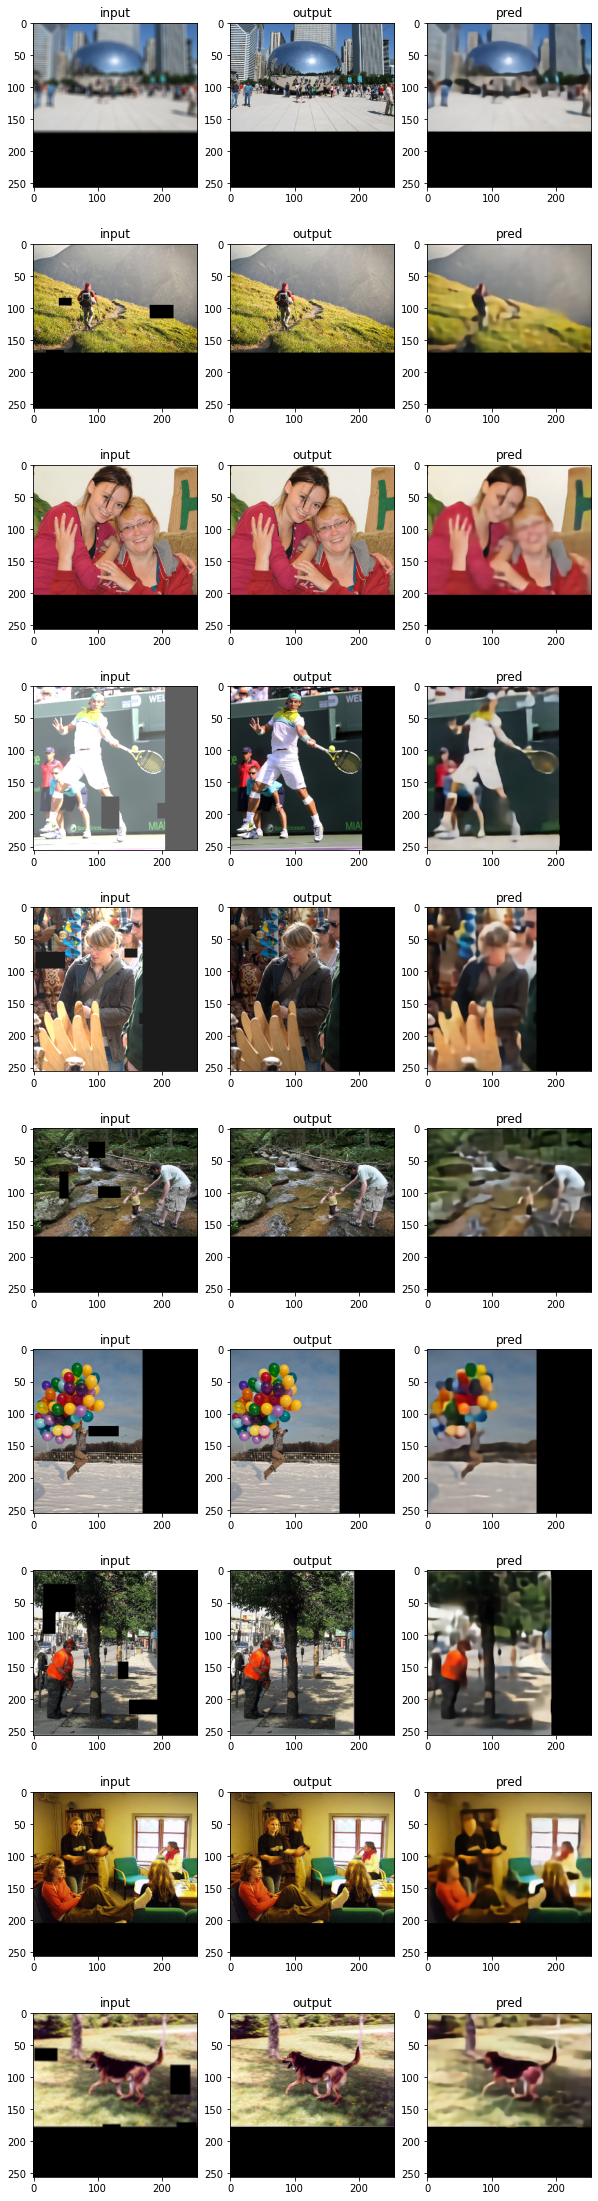

In [10]:
visualize_prediction(model, datasets['train'], save_path)

In [ ]:
torch.save(model.down.state_dict(), 'resnet18.pth')

In [ ]:
plot_latent_tsne(model, dataloaders['test'], save_path)

In [ ]:
model.load_state_dict?

## Lets trace the model

In [ ]:
def convert_embeddings(
    path: str,
    transforms,
) -> torch.Tensor:
    
    batch = torch.load(path).mul_(255).permute(0, 2, 3, 1).numpy().astype(np.uint8)
    new_batch = []
    
    for image in batch:
        new_batch.append(
            transforms(image=image)['image'],
        )
        
    new_batch = torch.stack(new_batch)
    
    return new_batch

In [ ]:
traced_module = torch.jit.trace(model.cpu(), torch.randn(1, 3, image_size[0], image_size[1]))
torch.jit.save(traced_module, os.path.join(save_path, 'model_traced.pt'))

In [ ]:
loaded = torch.jit.load(os.path.join(save_path, 'model_traced.pt'))
batch = convert_embeddings('health_dataset.pth', transformations['test'])

with torch.no_grad():
    embeddings = loaded(batch.cpu()).cpu()
    
torch.save(embeddings, os.path.join(save_path, 'embeddings.pth'))